In [22]:
%matplotlib inline
import os
os.sys.path.append('..')
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
from scipy.misc import imsave
import scipy.io
import warnings
import sys
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import scipy.misc

from darknet_multi import Darknet
from utils import *
import dataset_multi
from MeshPly import MeshPly

In [23]:
colors_pr = [( 83, 270,  73),(0,0,0),
( 82, 285, 253),
(175,  56,  43),
(124, 412, 482),
(343, 219, 204),
( 53, 458, 231),
(215,  70, 304),
( 46, 164, 149),
(272,  94,  69)]
colors_gt = [(246, 194,  53),(0,0,0),
 ( 95, 230,   4),
 ( 92,  46, 190),
 (343, 559, 168),
 (122,  70, 313),
 (151, 302, 342),
 (2,  87, 134),
 (131, 549, 198),
(356,  27, 233)]

In [24]:
colors = abs(np.random.randn(9,3))*255
colors = colors.astype('int')
print(colors)

[[452 429  11]
 [592  29 155]
 [361 306 170]
 [124  47  67]
 [122 357  50]
 [563  71 147]
 [ 82 225 496]
 [111 303  49]
 [307 239 412]]


In [25]:
import cv2
def draw(im, pts, c, draw_pairs):
    '''draw skeleton and mark joints using joint_id, depend on opencv'''
    img=im.copy()
    for pair in draw_pairs:
        i,j = pair
        x1=int(pts[i,0])
        x2=int(pts[j,0])
        y1=int(pts[i,1])
        y2=int(pts[j,1])
        if x1>0 and x2>0 and y1>0 and y2>0:
            img=cv2.line(img,(x1, y1), (x2, y2),tuple(c),3)
    return img

2019-05-05 15:02:43 Testing ape...
0
3
4
5
6
8
9
0


"datacfg = 'cfg/can_occlusion.data'\nvalid(datacfg, cfgfile, weightfile, conf_th)\ndatacfg = 'cfg/cat_occlusion.data'\nvalid(datacfg, cfgfile, weightfile, conf_th)\ndatacfg = 'cfg/duck_occlusion.data'\nvalid(datacfg, cfgfile, weightfile, conf_th)\ndatacfg = 'cfg/driller_occlusion.data'\nvalid(datacfg, cfgfile, weightfile, conf_th)\ndatacfg = 'cfg/glue_occlusion.data'\nvalid(datacfg, cfgfile, weightfile, conf_th)\ndatacfg = 'cfg/holepuncher_occlusion.data'\nvalid(datacfg, cfgfile, weightfile, conf_th)"

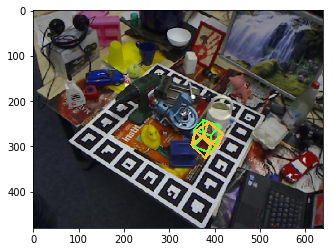

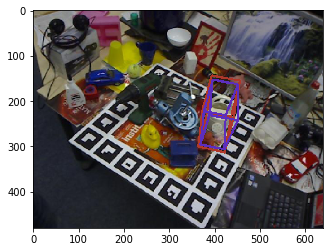

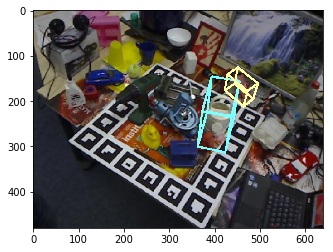

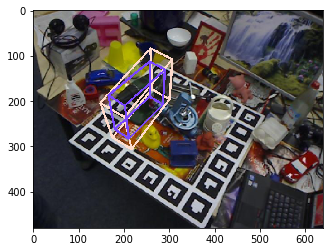

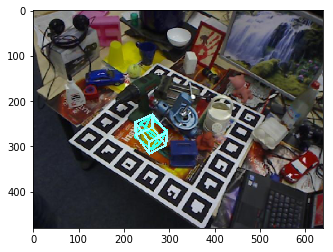

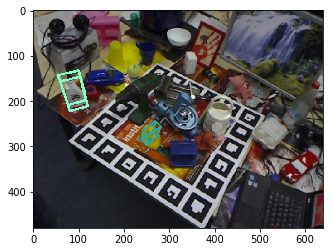

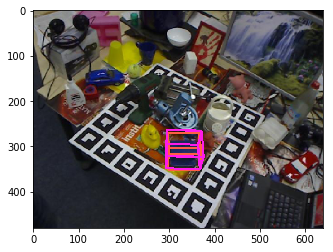

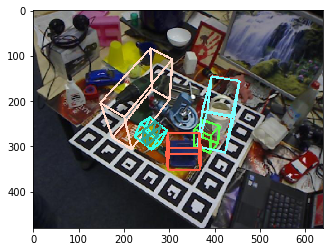

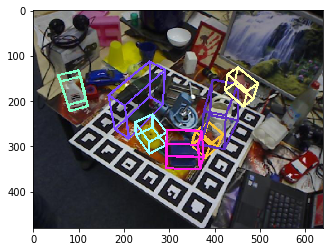

In [49]:
def valid(datacfg, cfgfile, weightfile, conf_th):
    def truths_length(truths):
        for i in range(50):
            if truths[i][1] == 0:
                return i

    # Parse configuration files
    options       = read_data_cfg(datacfg)
    valid_images  = options['valid']
    meshname      = options['mesh']
    name          = options['name']
    prefix        = 'results'
    # Read object model information, get 3D bounding box corners
    mesh          = MeshPly(meshname)
    objs_ape = { 'can':3, 'cat':4, 'driller':5, 'duck':6, 'eggbox':7,'glue':8, 'holepuncher':9}
    vertices      = np.c_[np.array(mesh.vertices), np.ones((len(mesh.vertices), 1))].transpose()
    corners3D     = get_3D_corners(vertices)
    corners = {0:corners3D.copy()}
    for obj in objs_ape.keys():
        mesh = MeshPly(meshname.replace('ape',obj))
        vertices      = np.c_[np.array(mesh.vertices), np.ones((len(mesh.vertices), 1))].transpose()
        corners3D     = get_3D_corners(vertices)
        corners[objs_ape[obj]] = corners3D.copy()
    # Read intrinsic camera parameters
    internal_calibration = get_camera_intrinsic()

    # Get validation file names
    with open(valid_images) as fp:
        tmp_files = fp.readlines()
        valid_files = [item.rstrip() for item in tmp_files]
    
    # Specicy model, load pretrained weights, pass to GPU and set the module in evaluation mode
    model = Darknet(cfgfile)
    model.load_weights(weightfile)
    model.cuda()
    model.eval()

    # Get the parser for the test dataset
    valid_dataset = dataset_multi.listDataset_multi(valid_images, shape=(model.width, model.height),
                       shuffle=False,
                       objclass=name,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                       ]))
    valid_batchsize = 1

    # Specify the number of workers for multiple processing, get the dataloader for the test dataset
    kwargs = {'num_workers': 4, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=1, shuffle=False, **kwargs) 

    # Parameters
    visualize       = True
    use_cuda        = True
    num_classes     = 13
    anchors         = [1.4820, 2.2412, 2.0501, 3.1265, 2.3946, 4.6891, 3.1018, 3.9910, 3.4879, 5.8851]
    num_anchors     = 5
    eps             = 1e-5
    conf_thresh     = conf_th
    iou_thresh      = 0.5

    # Parameters to save
    errs_2d = []
    edges = [[1, 2], [1, 3], [1, 5], [2, 4], [2, 6], [3, 4], [3, 7], [4, 8], [5, 6], [5, 7], [6, 8], [7, 8]]
    edges_corners = [[0, 1], [0, 2], [0, 4], [1, 3], [1, 5], [2, 3], [2, 6], [3, 7], [4, 5], [4, 6], [5, 7], [6, 7]]

    # Iterate through test batches (Batch size for test data is 1)
    count = 0
    logging('Testing {}...'.format(name))
    test = list(enumerate(test_loader))
    k = 407#int((np.random.rand(1)*len(test))[0])
    errmin =1000
    errk = 0
    for batch_idx, (data, target) in test[k:k+1]:
        
        img = data[0, :, :, :]
        img = img.numpy().squeeze()
        img = np.transpose(img, (1, 2, 0))
        img_ = scipy.misc.imresize(img, (480, 640))
        img_gt = img_.copy()
        img_pr = img_.copy()
        t1 = time.time()
        # Pass data to GPU
        if use_cuda:
            data = data.cuda()
        
        # Wrap tensors in Variable class, set volatile=True for inference mode and to use minimal memory during inference
        with torch.no_grad():
            data = Variable(data)
        t2 = time.time()
        
        # Forward pass
        output = model(data).data.cpu()  
        t3 = time.time()
        
        # Using confidence threshold, eliminate low-confidence predictions
        trgt = target[0].view(-1, 21)
        all_boxes = get_corresponding_region_boxes(output, conf_thresh, num_classes, anchors, num_anchors, int(trgt[0][0]), only_objectness=0)        
        t4 = time.time()
        # Iterate through all images in the batch
        for i in range(output.size(0)):
            
            # For each image, get all the predictions
            boxes   = all_boxes[i]
            
            # For each image, get all the targets (for multiple object pose estimation, there might be more than 1 target per image)
            truths  = target[i].view(-1, 21)
            
            # Get how many object are present in the scene
            num_gts = truths_length(truths)
            err = 0

            # Iterate through each ground-truth object
            for k in range(num_gts):
                box_gt        = [truths[k][1], truths[k][2], truths[k][3], truths[k][4], truths[k][5], truths[k][6], 
                                truths[k][7], truths[k][8], truths[k][9], truths[k][10], truths[k][11], truths[k][12], 
                                truths[k][13], truths[k][14], truths[k][15], truths[k][16], truths[k][17], truths[k][18], 1.0, 1.0, truths[k][0]]
                best_conf_est = -1
                cls = int(truths[k][0])
                if cls ==7:
                    continue
                corners3D = corners[cls]
                # If the prediction has the highest confidence, choose it as our prediction
                for j in range(len(boxes)):
                    if (boxes[j][18] > best_conf_est) and (boxes[j][20] == int(truths[k][0])):
                        best_conf_est = boxes[j][18]
                        box_pr        = boxes[j]
                        bb2d_gt       = get_2d_bb(box_gt[:18], output.size(3))
                        bb2d_pr       = get_2d_bb(box_pr[:18], output.size(3))
                        iou           = bbox_iou(bb2d_gt, bb2d_pr)
                        match         = corner_confidence9(box_gt[:18], torch.FloatTensor(boxes[j][:18]))   
                # Denormalize the corner predictions 
                corners2D_gt = np.array(np.reshape(box_gt[:18], [9, 2]), dtype='float32')
                corners2D_pr = np.array(np.reshape(box_pr[:18], [9, 2]), dtype='float32')
                corners2D_gt[:, 0] = corners2D_gt[:, 0] * 640
                corners2D_gt[:, 1] = corners2D_gt[:, 1] * 480               
                corners2D_pr[:, 0] = corners2D_pr[:, 0] * 640
                corners2D_pr[:, 1] = corners2D_pr[:, 1] * 480
                corners2D_gt_corrected = fix_corner_order(corners2D_gt) # Fix the order of the corners in OCCLUSION
                
                # Compute [R|t] by pnp
                objpoints3D = np.array(np.transpose(np.concatenate((np.zeros((3, 1)), corners3D[:3, :]), axis=1)), dtype='float32')
                K = np.array(internal_calibration, dtype='float32')
                R_gt, t_gt = pnp(objpoints3D,  corners2D_gt_corrected, K)
                R_pr, t_pr = pnp(objpoints3D,  corners2D_pr, K)
                
                # Compute pixel error
                Rt_gt        = np.concatenate((R_gt, t_gt), axis=1)
                Rt_pr        = np.concatenate((R_pr, t_pr), axis=1)
                proj_2d_gt   = compute_projection(vertices, Rt_gt, internal_calibration) 
                proj_2d_pred = compute_projection(vertices, Rt_pr, internal_calibration) 
                proj_corners_gt = np.transpose(compute_projection(corners3D, Rt_gt, internal_calibration)) 
                proj_corners_pr = np.transpose(compute_projection(corners3D, Rt_pr, internal_calibration)) 
                norm         = np.linalg.norm(proj_2d_gt - proj_2d_pred, axis=0)
                pixel_dist   = np.mean(norm)
                err +=pixel_dist
                img_pr = draw(img_pr,proj_corners_pr,colors_pr[cls],edges_corners)
                img_gt = draw(img_gt,proj_corners_gt,colors_gt[cls],edges_corners)
                img_obj = draw(img_,proj_corners_pr,colors_pr[cls],edges_corners)
                img_obj = draw(img_obj,proj_corners_gt,colors_gt[cls],edges_corners)
                plt.figure()
                plt.imshow(img_obj)
                print(cls)
                cv2.imwrite('res/img_'+str(cls)+'.png',img_obj)

                
                '''if visualize:
                    plt.figure()
                    # Visualize
                    plt.axis('off')
                    plt.xlim((0, 640))
                    plt.ylim((0, 480))
                    plt.imshow(scipy.misc.imresize(img, (480, 640)))
                    plt.gca().invert_yaxis()
                    plt.figure()
                    plt.axis('off')
                    # Visualize
                    plt.xlim((0, 640))
                    plt.ylim((0, 480))
                    plt.imshow(scipy.misc.imresize(img, (480, 640)))
                    # Projections
                    for edge in edges_corners:
                        plt.plot(proj_corners_gt[edge, 0], proj_corners_gt[edge, 1], color='y', linewidth=3.0)
                        plt.plot(proj_corners_pr[edge, 0], proj_corners_pr[edge, 1], color='b', linewidth=2.0)
                    plt.gca().invert_yaxis()'''
                    
            plt.figure()
            plt.imshow(img_pr)
            cv2.imwrite('res/img_pr.png',img_pr)
            plt.figure()
            plt.imshow(img_gt)
            cv2.imwrite('res/img_gt.png',img_gt)
            '''
            err /=num_gts
            if err<errmin:
                errmin = err
                errk = batch_idx'''

        t5 = time.time()
    print(errk)


conf_th = 0.3
cfgfile = 'cfg/yolo-pose-multi.cfg'
weightfile = '../checkpoint_multi/yolo-pose-multi-no-ohkm/model.weights'
datacfg = 'cfg/ape_occlusion.data'
valid(datacfg, cfgfile, weightfile, conf_th)
'''datacfg = 'cfg/can_occlusion.data'
valid(datacfg, cfgfile, weightfile, conf_th)
datacfg = 'cfg/cat_occlusion.data'
valid(datacfg, cfgfile, weightfile, conf_th)
datacfg = 'cfg/duck_occlusion.data'
valid(datacfg, cfgfile, weightfile, conf_th)
datacfg = 'cfg/driller_occlusion.data'
valid(datacfg, cfgfile, weightfile, conf_th)
datacfg = 'cfg/glue_occlusion.data'
valid(datacfg, cfgfile, weightfile, conf_th)
datacfg = 'cfg/holepuncher_occlusion.data'
valid(datacfg, cfgfile, weightfile, conf_th)'''

    